# Self-Driving Car Engineer Nanodegree

## Vehicle Detection and Tracking

In [198]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import random
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

%matplotlib inline

## Load Vehicle and Non-vehicle data

In [4]:
# Loading + training, validation test split
cars, nocar = [], []

cars += glob.glob('./vehicles/GTI_Far/*.png')
cars += glob.glob('./vehicles/GTI_MiddleClose/*.png')
cars += glob.glob('./vehicles/GTI_Left/*.png')
cars += glob.glob('./vehicles/GTI_Right/*.png')
cars += glob.glob('./vehicles/KITTI_extracted/*.png')
random.shuffle(cars)

nocar += glob.glob('./non-vehicles/Extras/*.png')
nocar += glob.glob('./non-vehicles/GTI/*.png')
random.shuffle(nocar)

## Step 1. Perform feature extraction using Histogram of Oriented Gradients (HOG), color transformation and color histogram on a labeled training set of images.

In [49]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True: # Call with two outputs if vis==True to visualize the HOG
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      # Otherwise call with one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    return cv2.resize(img, size).ravel() 

# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]#We need only the histogram, no bins edges
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist

In [109]:
# Define a function to extract features from a list of images
def img_features(feature_image, spatial_size, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat):
    file_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #print 'spat', spatial_features.shape
        file_features.append(spatial_features)
    if hist_feat == True:
         # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #print 'hist', hist_features.shape
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
        else:
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features(feature_image[:,:], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                #print 'hog', hog_features.shape
            # Append the new feature vector to the features list
        file_features.append(hog_features)
    return np.concatenate(file_features)

def extract_features(imgs, color_space='BGR', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file_p in imgs:
        file_features = []
        image = cv2.imread(file_p) # Read in each image one by one
        # apply color conversion if other than 'RGB'
        if color_space != 'BGR':
            if color_space == 'RGB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            elif color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)      
        file_features = img_features(feature_image, spatial_size, hist_bins, orient,
                        pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
        features.append(file_features)
        feature_image = cv2.flip(feature_image,1) # Augment the dataset with flipped images
        file_features = img_features(feature_image, spatial_size, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
        features.append(file_features)
    return features # Return list of feature vectors

/Users/minhnguyen/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:88: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)


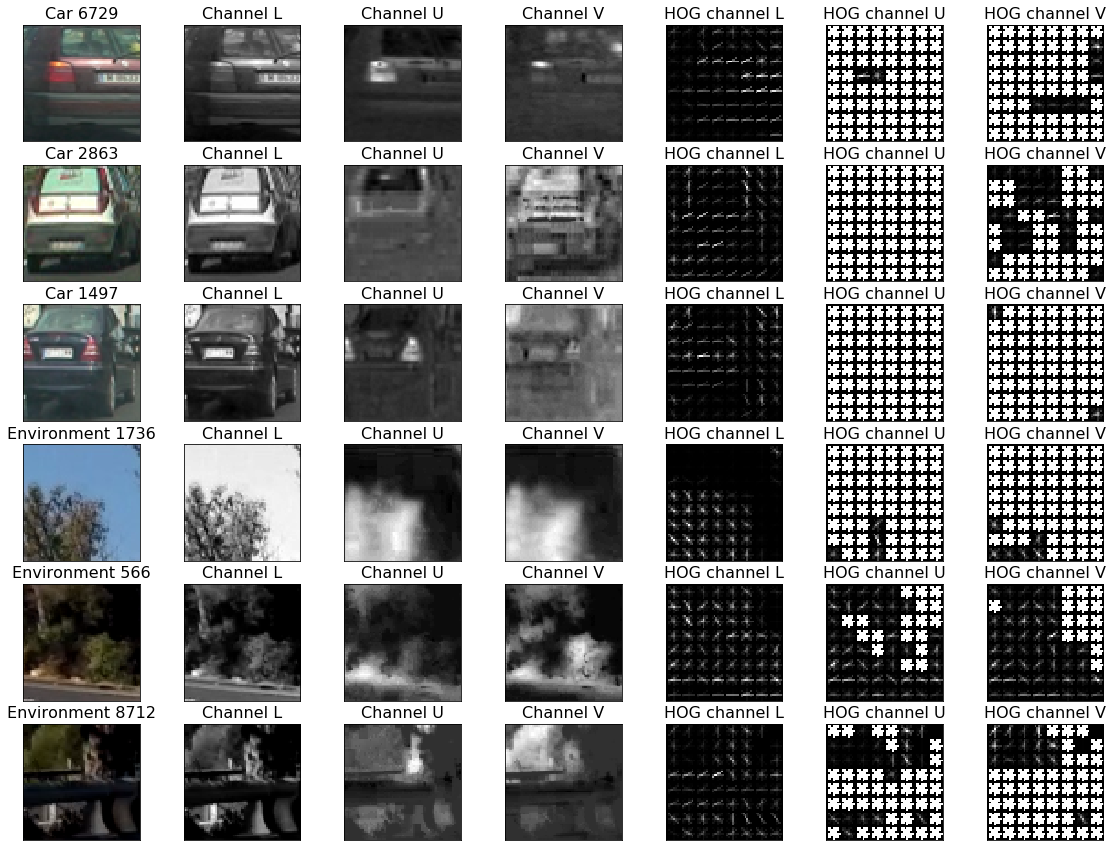

In [51]:
font_size=16
f, axes = plt.subplots(6, 7,figsize=(20,15))
f.subplots_adjust(hspace=0.2, wspace=0.05)

color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

if color_space == 'LUV':
    color = cv2.COLOR_RGB2LUV
if color_space == 'HLS':
    color = cv2.COLOR_RGB2HLS
if color_space == 'HSV':
    color=cv2.COLOR_RGB2HSV
channel = list(color_space)
if color_space == 'YCrCb':
    color=cv2.COLOR_RGB2YCrCb
    channel = ['Y', 'Cr', 'Cb']

j_cars = random.sample(range(0, len(cars)), 3)
j_nocar = random.sample(range(0, len(nocar)), 3)

for i,j in enumerate(j_cars + j_nocar):
    if i <= 2:
        image = mpimg.imread(cars[j])
    else:
        image = mpimg.imread(nocar[j])
    
    feature_image = cv2.cvtColor(image, color)

    axes[i,0].imshow(image)
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    if i <= 2:
        axes[i,0].set_title('Car ' + str(j), fontsize=font_size)
    else:
        axes[i,0].set_title('Environment ' + str(j), fontsize=font_size)

    for c in range(3):        
        axes[i, c+1].imshow(feature_image[:,:,c],cmap='gray')
        axes[i, c+1].set_title('Channel ' + channel[c], fontsize=font_size)
        axes[i, c+1].set_xticks([])
        axes[i, c+1].set_yticks([])    
    
    for c in range(3):
        features, hog_image = get_hog_features(feature_image[:,:,c], orient, pix_per_cell, 
                                              cell_per_block, vis=True, feature_vec=True)
        axes[i, c+4].imshow(hog_image,cmap='gray')
        axes[i, c+4].set_title('HOG channel ' + channel[c], fontsize=font_size)
        axes[i, c+4].set_xticks([])
        axes[i, c+4].set_yticks([])
              
plt.show()

In [60]:
t=time.time()
cars_feature = extract_features(cars, color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, 
    hog_channel, spatial_feat, hist_feat, hog_feat)
nocar_feature = extract_features(nocar, color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, 
    hog_channel, spatial_feat, hist_feat, hog_feat)
print('Feature extraction from images takes: ', round(time.time() - t, 3), ' seconds')

Feature extraction from images takes:  245.732  seconds


In [61]:
print('Car samples: ', len(cars_feature))
print('No car samples: ', len(nocar_feature))

Car samples:  17584
No car samples:  17936


## Step 2: Train Linear SVM Classifier

In [84]:
#  Put all features to a standard scale, whether they are spatial, hist or HOG
X = np.vstack((cars_feature, nocar_feature)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.transform(X) 

y = np.array([1]*len(cars_feature) + [0]*len(nocar_feature))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=22)

In [87]:
X_scaled.shape

(35520, 2432)

In [65]:
# Train SVC model
t = time.time()
clf = LinearSVC(loss='hinge')
clf.fit(X_train, y_train)
print('SVC takes: ', round(time.time() - t, 3), ' seconds to train.')
print('Train Accuracy: ', round(clf.score(X_train, y_train), 4))
print('Test Accuracy: ', round(clf.score(X_test, y_test), 4))

'''
parameters = {'C': [0.001, 0.01, 0.1]}
clf = GridSearchCV(svc, parameters, n_jobs=2)
clf.fit(X_train, y_train)
print('GridSearchCV on SVC takes: ', round(time.time() - t, 3), ' seconds to train.')
print('Best C value:', clf.best_params_)
print('Validation Accuracy: ', round(clf.score(X_val, y_val), 6))
print('Test Accuracy: ', round(clf.score(X_test, y_test), 6))

joblib.dump(clf, 'linear_svc.pkl')''';

SVC takes:  8.503  seconds to train.
Train Accuracy:  1.0
Test Accuracy:  0.9852


## Step 3: Sliding Multiscale Window Search

In [304]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [326]:
# Define a function you will pass a list of image paths
# and the list of windows to be searched
def search_windows(image, windows, clf, scaler, color_space='BGR', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    if color_space != 'BGR':
        if color_space == 'RGB':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(image) 
    
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(feature_image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using img_features()
        features = img_features(test_img, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        #print(features.shape)
        #print(np.array(features).reshape(1, -1).shape)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# A function to show an image
def show_img(img):
    if len(img.shape)==3: #Color BGR image
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else: # Grayscale image
        plt.imshow(img, cmap='gray')

10.18 Seconds to process test images


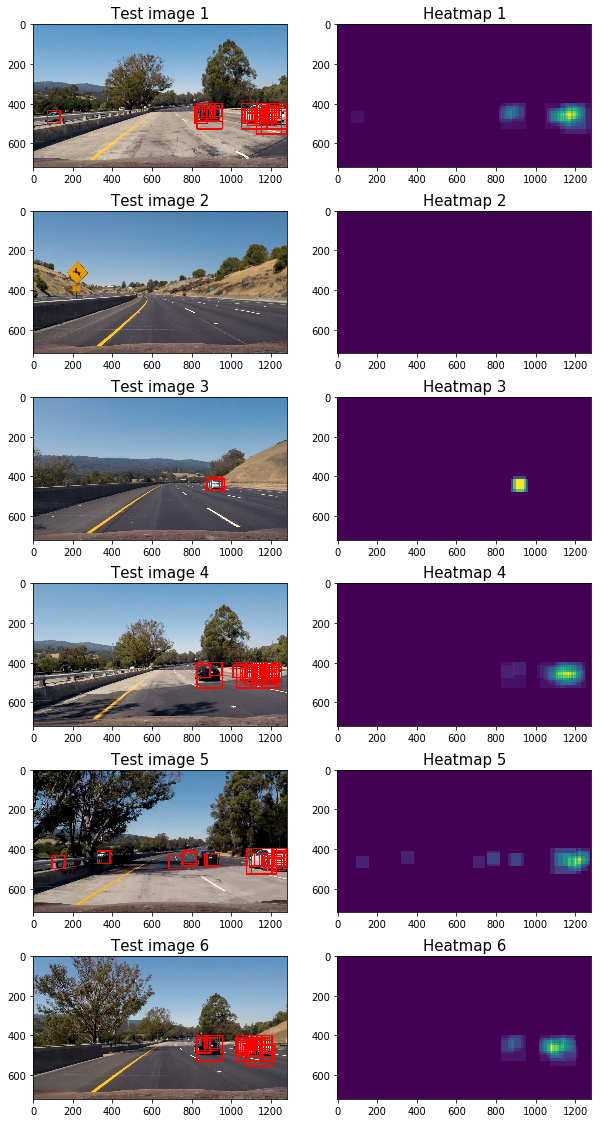

In [331]:
t=time.time() # Start time
font_size = 15

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes to add heat to pixels if they are in boxes
    for box in bbox_list:
        # Each box takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

test_images = glob.glob('test_images/test*.jpg')
fig, axes = plt.subplots(len(test_images),2, figsize=(10, 20))
for i, image_p in enumerate(test_images):
    image = cv2.imread(image_p)
    draw_image = np.copy(image)
    windows = []
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 520], 
                    xy_window=(64, 64), xy_overlap=(0.8, 0.8))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(128, 128), xy_overlap=(0.8, 0.8))
    
    hot_windows = []
    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
    #window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)      
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    
    #show_img(window_img)
    
    axes[i,0].imshow((cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB)))
    axes[i,0].set_title('Test image ' + str(i+1), fontsize=font_size)
    heatmap = np.zeros((720, 1280)).astype(np.float)
    heatmap = add_heat(heatmap, hot_windows)
    axes[i,1].imshow(heatmap)
    axes[i,1].set_title('Heatmap ' + str(i+1), fontsize=font_size)
    
print(round(time.time()-t, 2), 'Seconds to process test images')

## Step 4: Run the Pipeline on a Video Stream

In [306]:
def find_cars_reusability(image):
    #image = cv2.imread(image_p)
    #draw_image = np.copy(image)
    windows = []
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 520], 
                    xy_window=(64, 64), xy_overlap=(0.8, 0.8))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(128, 128), xy_overlap=(0.8, 0.8))
    hot_windows = []
    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    return hot_windows

In [321]:
THRES = 3 # Minimal overlapping boxes
ALPHA = 0.75 # Filter parameter, weight of the previous measurements

THRES_LEN = 32
Y_MIN = 440

In [324]:
def apply_threshold(heatmap, threshold): # Zero out pixels below the threshold in the heatmap
    heatmap[heatmap < threshold] = 0 
    return heatmap 

def filt(a, b, alpha): # Smooth the car boxes
    return a*alpha+(1.0-alpha)*b

def len_points(p1, p2): # Distance beetween two points
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def track_to_box(p): # Create box coordinates out of its center and span
    return ((int(p[0]-p[2]),int(p[1]-p[3])),(int(p[0]+p[2]), int(p[1]+p[3])))

def draw_labeled_bboxes(labels):
    global track_list
    track_list_l = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #img = draw_boxes(np.copy(img), [bbox], color=(255,0,255), thick=3)
        size_x = (bbox[1][0]-bbox[0][0])/2.0 #Size of the found box
        size_y = (bbox[1][1]-bbox[0][1])/2.0
        asp_d = size_x / size_y
        size_m = (size_x + size_y)/2
        x = size_x+bbox[0][0]
        y = size_y+bbox[0][1]
        asp = (y-Y_MIN)/130.0+1.2 # Best rectangle aspect ratio for the box (coefficients from perspectieve measurements and experiments)
        if x>1050 or x<230:
            asp*=1.4
        asp = max(asp, asp_d) # for several cars chunk
        size_ya = np.sqrt(size_x*size_y/asp)
        size_xa = int(size_ya*asp)
        size_ya = int(size_ya)
        if x > (-3.049*y+1809): #If the rectangle on the road, coordinates estimated from a test image
            track_list_l.append(np.array([x, y, size_xa, size_ya]))
            if len(track_list) > 0:
                track_l = track_list_l[-1]
                dist = []
                for track in track_list:
                    dist.append(len_points(track, track_l))
                min_d = min(dist)
                if min_d < THRES_LEN:
                    ind = dist.index(min_d)
                    track_list_l[-1] = filt(track_list[ind], track_list_l[-1], ALPHA)
    track_list = track_list_l
    boxes = []
    for track in track_list_l:
        #print(track_to_box(track))
        boxes.append(track_to_box(track))
    return boxes

In [356]:
# heatmap memory of 2 frames
heat_series = [np.zeros((720, 1280)).astype(np.float)] * 2
error_no = 0
# image processing pipeline
def frame_proc_simple(img, clf, video = False, vis = False):
    global heat_series, error_no, heat_p, boxes_p, n_count
    
    if (video & n_count%2==0) or not video: # Skip every second video frame
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        boxes = []
        boxes = find_cars_reusability(img)
        heat = add_heat(heat, boxes)
        #heat_curr = heat#heat_p + heat
        #heat_p = heat
        heat_series = heat_series[1:] + [heat]
        heat_curr = 0.5*heat_series[0] + heat_series[1]  # Put higher weight for current frame to increase flexibility
        heat_curr = apply_threshold(heat_curr, THRES) # Apply threshold to help remove false positives
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat_curr, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        try:
            cars_boxes = draw_labeled_bboxes(labels)
        except:
            cv2.imwrite('error_image' + str(error_no) + '.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            error_no += 1
            cars_boxes = boxes_p
        boxes_p = cars_boxes
    else:
        cars_boxes = boxes_p
    
    imp = draw_boxes(np.copy(img), cars_boxes, color=(0, 0, 255), thick=6)
    if vis:
        imp = draw_boxes(imp, boxes, color=(0, 255, 255), thick=3)
        for track in track_list:
            cv2.circle(imp, (int(track[0]), int(track[1])), 5, color=(255, 0, 255), thickness=2)
    n_count += 1
    return imp

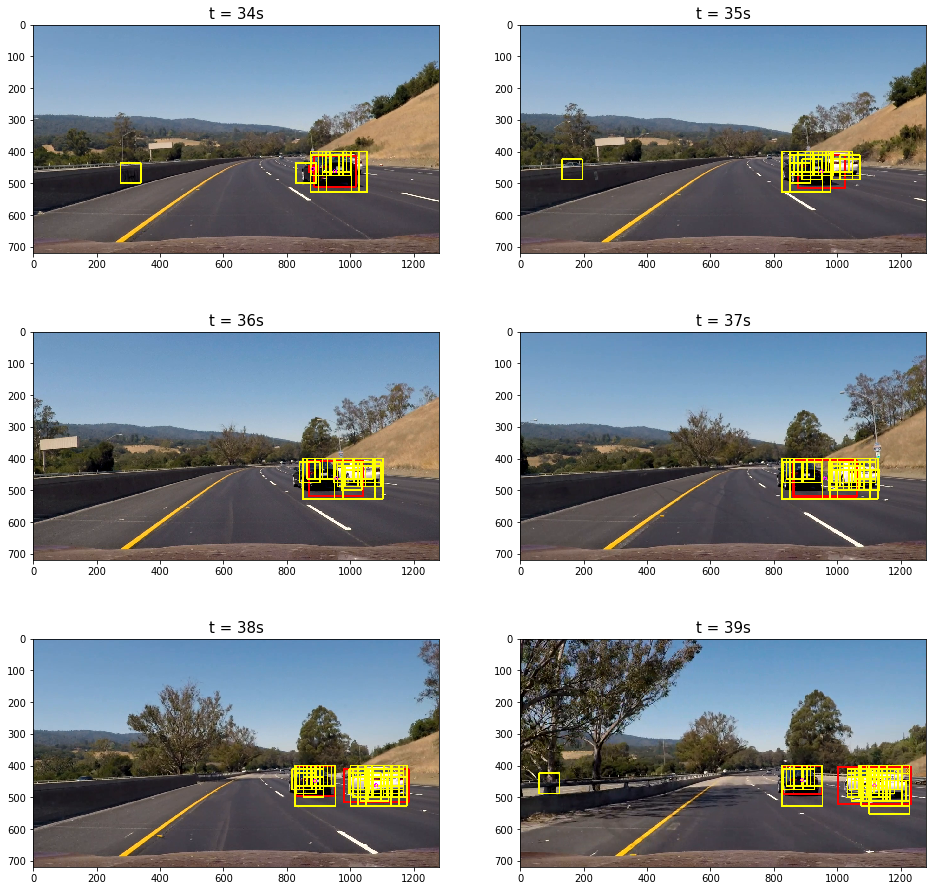

In [341]:
# produce some time series images from the road to test the frame_proc_simple function.
clip1 = VideoFileClip("project_video.mp4")
for i in list(range(30, 32)):
    clip1.save_frame("time_series/frame" + str(i) + ".png", t=i)

heat_series = [np.zeros((720, 1280)).astype(np.float)] * 2
track_list = []
heat_p = np.zeros((720, 1280)) # Store prev heat image
boxes_p = [] # Store prev car boxes
n_count = 0 # Frame counter

fig, axes = plt.subplots(3,2,figsize=(16,16))
#fig.subplots_adjust(hspace=0.2, wspace=0.05)
for i, ax in enumerate(axes.flat):
    j = i + 34  # start from t = 34s of the video
    image = cv2.imread('frame' + str(j) + '.png')
    output = frame_proc_simple(image, clf, vis=True)
    ax.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    ax.set_title('t = ' + str(j) + 's',fontsize = 15)
'''
t1 = time.time()
for i in list(range(35, 40)):
    image = cv2.imread('frame' + str(i) + '.png')
    plt.figure(figsize=(10,3))
    output = frame_proc_simple(image, clf, vis=True)
print(time.time() - t1, 'seconds')''';

In [358]:
# PRODUCE THE VIDEO
heat_series = [np.zeros((720, 1280)).astype(np.float)] * 2
track_list = []
heat_p = np.zeros((720, 1280)) # Store prev heat image
boxes_p = [] # Store prev car boxes
n_count = 0 # Frame counter

def process_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(frame_proc_simple(image, clf, video=True, vis=False), cv2.COLOR_BGR2RGB)

output_v = 'output_images/project_video_processed.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(15,16)
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output_v, audio=False)

[MoviePy] >>>> Building video output_images/project_video_processed.mp4
[MoviePy] Writing video output_images/project_video_processed.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 2/1261 [00:01<16:43,  1.25it/s]


  0%|          | 4/1261 [00:03<16:35,  1.26it/s]


  0%|          | 6/1261 [00:04<16:21,  1.28it/s]


  1%|          | 8/1261 [00:06<16:27,  1.27it/s]


  1%|          | 10/1261 [00:07<16:35,  1.26it/s]


  1%|          | 12/1261 [00:09<16:37,  1.25it/s]


  1%|          | 14/1261 [00:11<17:42,  1.17it/s]


  1%|▏         | 16/1261 [00:13<17:35,  1.18it/s]


  1%|▏         | 18/1261 [00:14<17:39,  1.17it/s]


  2%|▏         | 20/1261 [00:16<17:25,  1.19it/s]


  2%|▏         | 22/1261 [00:18<17:04,  1.21it/s]


  2%|▏         | 24/1261 [00:19<17:15,  1.19it/s]


  2%|▏         | 26/1261 [00:21<16:54,  1.22it/s]


  2%|▏         | 28/1261 [00:22<16:28,  1.25it/s]


  2%|▏         | 30/1261 [00:24<16:09,  1.27it/s]


  3%|▎         | 32/1261 [00:26<17:29,  1.17it/s]


  3%|▎         | 34/1261 [00:28<17:36,  1.16it/s]


  3%|▎         | 36/1261 [00:29<16:53,  1.21it/s]


  3%|▎         | 38/12

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_processed.mp4 

CPU times: user 17min 55s, sys: 32.8 s, total: 18min 28s
Wall time: 18min 54s
